# Machine Learning Final Project

*Student name: Cao Đình Hoàng Minh*

*MSSV: 19020063*

*Class ID: INT3405E_20*

# 1. Problem Descriptions
- Quora is a question and answer website where people go to find information. Every piece of content on the site is generated by users, meaning it is created, edited, and organized by the same people that use the website.
- Quora has some qualities that those other research tools don’t:
  + It allows users to create social networks and follow topics that interest them. 
  + It focuses on high-quality questions and answers. 
  + It enable users to vote on answers to highlight the most accurate information possible. 
- As being in top 10 most visited social networks in the world, censoring the content of questions is also an extremely important factor to make the value of this social network
- This problem focus on determining whether a question asked on Quora is insincere or not. The input is a text string and the output is 0 (sincere) or 1 (insincere)

# 2. Data analyzing, cleaning & pre-processing
**a. Data analyzing**
- First we need to import some libraries and modules

In [ ]:
# Just for checking folders 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))      
        
# Prevent all kinds of warning in all output 
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plot some graphs
from wordcloud import WordCloud # for words statistics

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

- Then we read the necessary csv files

In [ ]:
# Training data
train_data = pd.read_csv("../input/quora-insincere-questions-classification/train.csv")
# Testing data
test_data = pd.read_csv("../input/quora-insincere-questions-classification/test.csv")

- We can see that there are 1306122 questions in the training set and 375806 questions on the test set. All of them are not null

In [ ]:
# Show some information 
train_data.info()
test_data.info()

- Let's take a look at those files

In [ ]:
train_data.head(20)

- In the train file we have 3 columns:
  + qid: The question id
  + question_text: The question we need to predict
  + target: Mark the question as sincere (0) or insincere (1)

In [ ]:
test_data.head(20)

- In the test file we have 2 columns:
  + qid: The question id
  + question_text: The question we need to and predict

- Let's count the number of each kind of questions

In [ ]:
sincere_questions = train_data[train_data['target']==0]
insincere_questions = train_data[train_data['target']==1]
num_of_sincere = sincere_questions.shape[0]
num_of_insincere = insincere_questions.shape[0]
print("Number Of Sincere Questions:", num_of_sincere)
print("Number Of Insincere Questions:", num_of_insincere)
quantity = [num_of_sincere, num_of_insincere]
labels = ['Sincere Questions', 'Insincere Questions']
plt.pie(quantity, labels=labels, autopct='%1.2f%%', shadow=False)
plt.title('Target Distribution')
plt.show()

- Bad news here, we have too many sincere questions in the training set, which can badly affect the model's accuracy. To prevent this, we should use f1-score, which is the harmonic mean of precision and recall
- Precision is the ability of a model to identify only the insincere questions
- Recall is the ability of a model to find all the insincere questions

$$Precision = \frac{True Positive}{True Positive + False Positive}$$

$$Recall = \frac{True Positive}{True Positive + False Negative}$$

$$F1 = \frac{2}{Recall^{-1} + Precision^{-1}}$$


- Before we are going to clean the data, we will see which words appear the most in each kinds of questions

In [ ]:
sincere_wordcloud = WordCloud(width=800, height=450, background_color='white', min_font_size=10).generate(" ".join(sincere_questions.question_text))
plt.figure(figsize=(16,9), facecolor=None)
plt.imshow(sincere_wordcloud)
plt.axis("off")
plt.title("Common Words in Sincere Questions", fontsize=30,color='k')
plt.tight_layout(pad=0)
plt.show();

In [ ]:
insincere_wordcloud = WordCloud(width=800, height=450, background_color='white', min_font_size=10).generate(" ".join(insincere_questions.question_text))
plt.figure(figsize=(16,9), facecolor=None)
plt.imshow(insincere_wordcloud)
plt.axis("off")
plt.title("Common Words in Insincere Questions", fontsize=30,color='k')
plt.tight_layout(pad=0)
plt.show();

- As we can see there are some offensive words (pornography, racist, political,..) appearing a lot in the insincere questions.

**b. Data cleaning**
- First we need some arrays to store the main data

In [ ]:
# 4/5 of the questions wil be used to train
# the rest of them are used for validations
train_ratio = 0.8 
num_of_train  = int(train_ratio * (num_of_sincere + num_of_insincere))
train_sen = [] # array of training questions
val_sen = [] # array of validating questions
test_sen = [] # array of testing questions

for i in range(0, len(train_data['question_text'])):
    if i < num_of_train:
        train_sen.append(train_data['question_text'].loc[i])
    else:
        val_sen.append(train_data['question_text'].loc[i])
        
for i in range(0, len(test_data['question_text'])):
    test_sen.append(test_data['question_text'].loc[i])

train_label = [] # array of training questions' labels
val_label = [] # array of validating questions' labels
for i in range(0, len(train_data['target'])):
    if i < num_of_train:
        train_label.append(float(train_data['target'].loc[i]))
    else:
        val_label.append(float(train_data['target'].loc[i]))

- Stop words are the words which are generally filtered out before processing a natural language are called stop words. These are actually the most common words in any language (like articles, prepositions, pronouns, conjunctions, etc) and does not add much information to the text.

In [ ]:
allStopWords = "x y your yours yourself yourselves you yond yonder yon ye yet z zillion j u umpteen usually us username uponed upons uponing upon ups upping upped up unto until unless unlike unliker unlikest under underneath use used usedest r rath rather rathest rathe re relate related relatively regarding really res respecting respectively q quite que qua n neither neaths neath nethe nethermost necessary necessariest necessarier never nevertheless nigh nighest nigher nine noone nobody nobodies nowhere nowheres no noes nor nos no-one none not notwithstanding nothings nothing nathless natheless t ten tills till tilled tilling to towards toward towardest towarder together too thy thyself thus than that those thou though thous thouses thoroughest thorougher thorough thoroughly thru thruer thruest thro through throughout throughest througher thine this thises they thee the then thence thenest thener them themselves these therer there thereby therest thereafter therein thereupon therefore their theirs thing things three two o oh owt owning owned own owns others other otherwise otherwisest otherwiser of often oftener oftenest off offs offest one ought oughts our ours ourselves ourself out outest outed outwith outs outside over overallest overaller overalls overall overs or orer orest on oneself onest ons onto a atween at athwart atop afore afterward afterwards after afterest afterer ain an any anything anybody anyone anyhow anywhere anent anear and andor another around ares are aest aer against again accordingly abaft abafter abaftest abovest above abover abouter aboutest about aid amidst amid among amongst apartest aparter apart appeared appears appear appearing appropriating appropriate appropriatest appropriates appropriater appropriated already always also along alongside although almost all allest aller allyou alls albeit awfully as aside asides aslant ases astrider astride astridest astraddlest astraddler astraddle availablest availabler available aughts aught vs v variousest variouser various via vis-a-vis vis-a-viser vis-a-visest viz very veriest verier versus k g go gone good got gotta gotten get gets getting b by byandby by-and-by bist both but buts be beyond because became becomes become becoming becomings becominger becomingest behind behinds before beforehand beforehandest beforehander bettered betters better bettering betwixt between beneath been below besides beside m my myself mucher muchest much must musts musths musth main make mayest many mauger maugre me meanwhiles meanwhile mostly most moreover more might mights midst midsts h huh humph he hers herself her hereby herein hereafters hereafter hereupon hence hadst had having haves have has hast hardly hae hath him himself hither hitherest hitherer his how-do-you-do however how howbeit howdoyoudo hoos hoo w woulded woulding would woulds was wast we wert were with withal without within why what whatever whateverer whateverest whatsoeverer whatsoeverest whatsoever whence whencesoever whenever whensoever when whenas whether wheen whereto whereupon wherever whereon whereof where whereby wherewithal wherewith whereinto wherein whereafter whereas wheresoever wherefrom which whichever whichsoever whilst while whiles whithersoever whither whoever whosoever whoso whose whomever s syne syn shalling shall shalled shalls shoulding should shoulded shoulds she sayyid sayid said saider saidest same samest sames samer saved sans sanses sanserifs sanserif so soer soest sobeit someone somebody somehow some somewhere somewhat something sometimest sometimes sometimer sometime several severaler severalest serious seriousest seriouser senza send sent seem seems seemed seemingest seeminger seemings seven summat sups sup supping supped such since sine sines sith six stop stopped p plaintiff plenty plenties please pleased pleases per perhaps particulars particularly particular particularest particularer pro providing provides provided provide probably l layabout layabouts latter latterest latterer latterly latters lots lotting lotted lot lest less ie ifs if i info information itself its it is idem idemer idemest immediate immediately immediatest immediater in inwards inwardest inwarder inward inasmuch into instead insofar indicates indicated indicate indicating indeed inc f fact facts fs figupon figupons figuponing figuponed few fewer fewest frae from failing failings five furthers furtherer furthered furtherest further furthering furthermore fourscore followthrough for forwhy fornenst formerly former formerer formerest formers forbye forby fore forever forer fores four d ddays dday do doing doings doe does doth downwarder downwardest downward downwards downs done doner dones donest dos dost did differentest differenter different describing describe describes described despiting despites despited despite during c cum circa chez cer certain certainest certainer cest canst cannot cant cants canting cantest canted co could couldst comeon comeons come-ons come-on concerning concerninger concerningest consequently considering e eg eight either even evens evenser evensest evened evenest ever everyone everything everybody everywhere every ere each et etc elsewhere else ex excepted excepts except excepting exes enough"
stopWords = allStopWords.split(" ")

- The below function can help filtering out the stop words for better performances

In [ ]:
# Paramater: String, for example "I like machine learning"
def removeStop(sentence): 
    words = sentence.split(" ")
    ans = ""
    for s in words:
        try: 
            index = stopWords.index(s)
        except:
            ans += (s + " ")
    return ans

- Then we apply this method on all sentences to complete the cleaning phase

In [ ]:
for i in range(0, len(train_sen)):
    if not isinstance(train_sen[i], str):
        train_sen[i] = str(train_sen[i])
    train_sen[i] = removeStop(train_sen[i])

for i in range(0, len(val_sen)):
    if not isinstance(val_sen[i], str):
        val_sen[i] = str(val_sen[i])
    val_sen[i] = removeStop(val_sen[i])

for i in range(0, len(test_sen)):
    if not isinstance(test_sen[i], str):
        test_sen[i] = str(test_sen[i])
    test_sen[i] = removeStop(test_sen[i])

**c. Data pre-processing**
- To help the model understand those questions, we need to convert those questions into some sequences of numbers by using Tokenizer

In [ ]:
vocab_size = 30000 # the maximum number of words to keep, based on word frequency. Only the most common 30000 words will be kept
embedding_dim = 64
max_length = 64 # Most questions have less than 64 words, so it can be set to the maximum length of all sequences
trunc_type = 'post' # Remove values from sequences larger than maxlen at the end of the sequences.
pad_type = 'post' # Pad after each sequence, if it's not long enough
oov_tok = "<OOV>" # If given, it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sen)

train_seq = tokenizer.texts_to_sequences(train_sen)
train_pad = pad_sequences(train_seq, maxlen=max_length, padding=pad_type, truncating=trunc_type)

val_seq = tokenizer.texts_to_sequences(val_sen)
val_pad = pad_sequences(val_seq, maxlen=max_length, padding=pad_type, truncating=trunc_type)

test_seq = tokenizer.texts_to_sequences(test_sen)
test_pad = pad_sequences(test_seq, maxlen=max_length, padding=pad_type, truncating=trunc_type)

input1 = keras.Input(len(train_pad[0]))

embedded_vector = layers.Embedding(vocab_size, embedding_dim)(input1)

# 3. Model Description
**a. Select Model**
- The model selected here is Long Short-Term Memory (LTSM), which is an artificial Recurrent Neural Network (RNN) architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can process not only single data points (such as images), but also entire sequences of data (text)
- LSTM is still an RNN in essence, but the cycle a in the figure above has been redesigned to solve the problem of memory time is not long enough. Other neural networks try to adjust parameters to make memory better. As a result, LSTM is born to remember, which is a blow to dimension reduction!
- A in the ordinary RNN is shown in the figure below. The previous input and the current input are operated once. Tanh is used in the figure

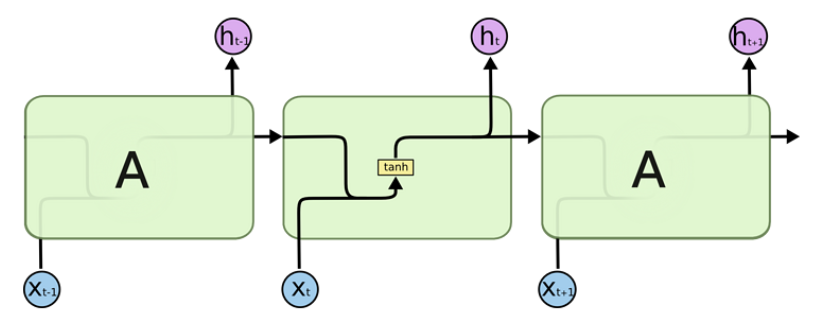

- In comparison, a in LSTM is much more complex. It is not a single neural network layer in the figure above, but has four layers, as shown in the figure below. =

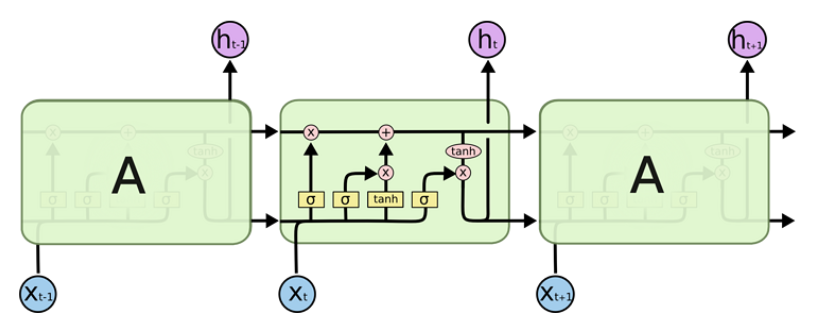

In [ ]:
hidden_class_1 = layers.LSTM(64)(embedded_vector)
hidden_class_1 = keras.Model(inputs=input1, outputs=hidden_class_1)

hidden_class = hidden_class_1.output
output = layers.Dense(2, activation='softmax')(hidden_class) # Use softmax activation function

model = keras.Model(inputs=[hidden_class_1.input], outputs=output)

model.summary()
train_label = np.array(train_label)
val_label = np.array(val_label)

**b. Train Model**
- Since metrics have been removed from Keras core, only accuracy and loss are available, we need to calculate the precision, recall and f1-score manually

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon()) # Prevent from dividing by 0
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon()) # Prevent from dividing by 0
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon())) # Prevent from dividing by 0

- We are ready to train now

In [ ]:
loss_function = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='Adam', loss=loss_function, metrics=['accuracy',recall_m,precision_m,f1_m])
history = model.fit(x=[train_pad], y=train_label, batch_size=32, epochs=2, validation_data=(val_pad, val_label))

**c. Validation**

- Now we will test the model on validation set

In [ ]:
validation_check = model.evaluate(x=[val_pad], y=val_label, verbose=1)

**d. Predict the output**
- Now we will use this trained model to predict the questions in the test file

In [ ]:
pred_y = model.predict([test_pad], batch_size=1024, verbose=1)

- The pred_y is representing the probability of each label (first number: label 0, second number: label 1), not 0 or 1
- Therefore we need one more step to convert it to an array of 0&1 to complete the prediction and submit the csv file

In [ ]:
ans = []
for prediction in pred_y:
    ans.append((prediction[1]*2).astype(int)) # if the value of label 1 is not less than 0.5, the model will predict it's 1
data_submit = pd.DataFrame({"qid":test_data["qid"].values})
data_submit['prediction'] = ans
data_submit.to_csv("submission.csv", index=False)
data_submit

**e. Summary by graph**

In [ ]:
# Graph of model loss
import matplotlib.pyplot as plt # plot some graphs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
# Graph of training accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
# Graph of f1
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('model f1')
plt.ylabel('f1_m')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()